In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime

1) Log file is loaded

In [2]:
file = open("log.txt", "r") 
lines = file.readlines()
for l in range(3): print(lines[l][:-1])

156.15.13.173 [01/Jan/2018:11:13:49 +0100] "GET AddProduct.html HTTP/1.0" 200 2356
176.247.135.49 [01/Jan/2018:11:18:07 +0100] "GET Shop.html HTTP/1.0" 200 7466
176.247.135.49 [01/Jan/2018:11:19:05 +0100] "GET AddProduct.html HTTP/1.0" 200 2356


2) Cass "Request" parses and keeps data of a single requests. Complete the TODO, where a given "line" (string) should be parsed in order to dervie the ip of the host making the request, time of the request (in seconds), and target page (name).

In [3]:
class Request:
    def __init__(self, line):
        # TODO DO PARSING HERE
        lista = line.split()
        self.ip = lista[0]
        date = lista[1]
        self.time = int(date[-2:]) + int(date[-5:-3]) * 60 + int(date[-8:-6]) * 60 * 60
        self.page = lista[4]
        # convert hours + minutes + seconds -> total number of seconds
        
    def __repr__(self):
        return self.ip + "     " +  str(datetime.timedelta(seconds=self.time)) + " -> " + self.page


3) Each line of log.txt is parsed and the Request objects are added to the list

In [4]:
reqs = [Request(line) for line in lines]
for l in range(10): print(reqs[l]) 

156.15.13.173     11:13:49 -> AddProduct.html
176.247.135.49     11:18:07 -> Shop.html
176.247.135.49     11:19:05 -> AddProduct.html
176.247.135.49     11:29:05 -> Summary.html
69.84.30.199     11:43:59 -> Shop.html
69.84.30.199     11:45:16 -> AddProduct.html
57.116.45.120     11:46:45 -> AddProduct.html
69.84.30.199     11:50:36 -> Summary.html
69.84.30.199     11:52:38 -> Payment.html
26.19.183.202     11:53:11 -> AddProduct.html


# Exercise

Your task is to analyze the log file. You should indentify the users and sessions. Then, compute the following: <br>
3.1) the number of sessions (should be 1000 :) ), <br>
3.2) the number of users, <br>
3.3) the average number of sessions per one user <br>
3.4) use the distribution plot to visualize the sessions' lengths (minutes);  <br>
3.5) use the distribution plot to visualize the sessions' lengths (the number of requests) <br>
3.6) use the distribution plot to visualize sessions' starting times (hours). <br>
3.7) which web page is the most common entry point?; for each page plot the number of times it has been an entry page,  <br>
3.8) which web page is the most common departure point?; for each page plot the number of times the user stopped a session while being on this page, <br>
3.9) for each page plot the average time the user stayed on this page <br>
3.10) print the fist 10 sessions (paths). <br>

You may find the following classes helpful and data.

sum of sessions:  1000
sum of users:  391
average number of sessions per one user:  2.558


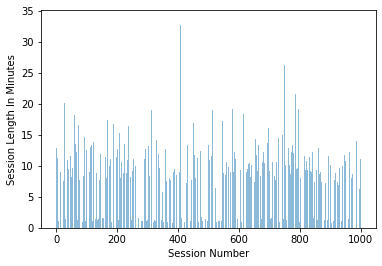

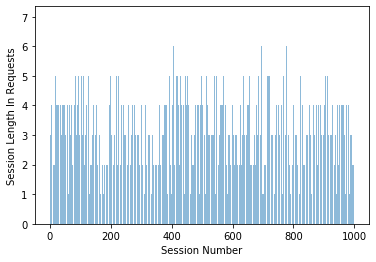

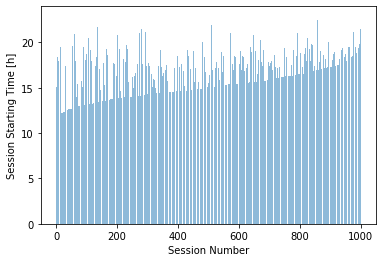

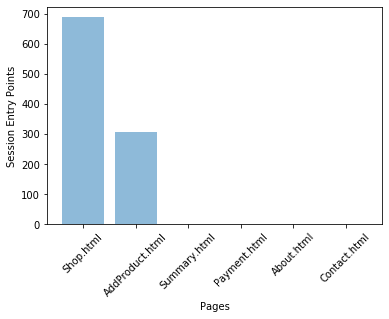

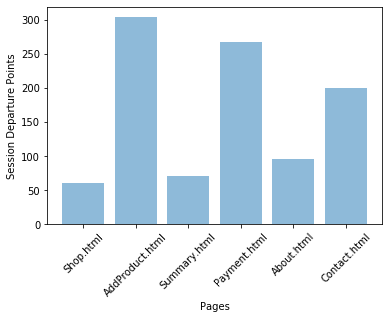

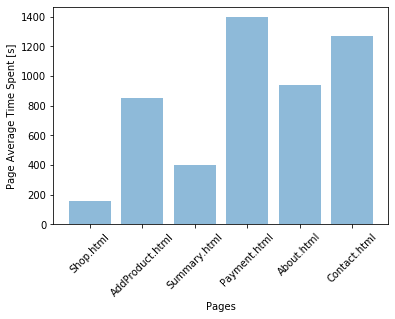

10 SESSIONS PATHS:
1 ) AddProduct.html
2 ) Shop.html => AddProduct.html => Summary.html
3 ) Shop.html => AddProduct.html => Summary.html => Payment.html
4 ) AddProduct.html => Summary.html => Payment.html
5 ) AddProduct.html => About.html => Contact.html
6 ) Shop.html => AddProduct.html
7 ) Shop.html => About.html
8 ) Shop.html => About.html => Contact.html
9 ) Shop.html
10 ) AddProduct.html


In [78]:
class Session:
    def __init__(self, request):
        self.isClosed = False
        self.startTime = request.time
        self.stopTime = request.time
        self.requests = []
        self.requests.append(request)
        
    def __repr__(self):
        print("SESSION")
        print(self.startTime)
        print(self.stopTime)
        STR = ""
        for r in self.requests:
            print(r)
            STR += ("  " + r.page + "    " + str(datetime.timedelta(seconds=r.time)) + "\n")
        return STR

    def pushRequest(self, request):
        self.requests.append(request)
        self.stopTime = request.time

    def closeSession(self):
        self.isClosed = True

    def getSessionLengthInMinutes(self):
        return (self.stopTime - self.startTime) / 60

    def getRequestsNumber(self):
        return len(self.requests)

    def getSessionStartTimeInHours(self):
        return self.startTime / 60 / 60

    def getTimeSpentOnPage(self, i):
        return self.requests[i + 1].time - self.requests[i].time

class Computer:
    def __init__(self, ip, session):
        self.ip = ip
        self.sessions = []
        self.sessions.append(session)

    def __repr__(self):
        return self.ip

    def pushSession(self, session):
        self.sessions.append(session)

PAGES = ["Shop.html", "AddProduct.html", "Summary.html", "Payment.html", "About.html", "Contact.html"]

LINKS = [[1, 4], 
         [2,4],
         [3],
         [],
         [1,5],
         []]

def isInTheSameSession(first, last, new): # requests
    if last.time > new.time:
        return False
    elif new.time - first.time > 34 * 60:
        return False
    elif last.page == new.page:
        return True
    elif len(LINKS[PAGES.index(last.page)]) == 0:
        return False
    elif PAGES.index(new.page) in LINKS[PAGES.index(last.page)]:
        return True
    return False

users = []

for req in reqs:
    new_user = True
    for user in users:
        if req.ip != user.ip:
            continue
        
        new_user = False
        for session in user.sessions: 
            if session.isClosed:
                continue
            elif isInTheSameSession(session.requests[0], session.requests[-1], req):
                session.pushRequest(req)
            else: 
                session.closeSession()
                user.pushSession(Session(req))
        break

    if new_user:
        users.append(Computer(ip=req.ip, session=Session(req)))
        
sessions_sum = 0
sessions_objects = []
sessions_length_minutes = []
sessions_length_requests = []
sessions_starting_times = []
sessions_entry_points = np.zeros(len(PAGES), dtype=int)
sessions_departure_points = np.zeros(len(PAGES), dtype=int)
pages_time_spent = np.zeros(len(PAGES), dtype=int)
pages_entries = np.zeros(len(PAGES), dtype=int)

for user in users:
    sessions_sum += len(user.sessions)
    for j, session in enumerate(user.sessions):
        sessions_objects.append(session)
        sessions_length_minutes.append(session.getSessionLengthInMinutes())
        sessions_length_requests.append(len(session.requests))
        sessions_starting_times.append(session.getSessionStartTimeInHours())
        sessions_entry_points[PAGES.index(session.requests[0].page)] += 1
        sessions_departure_points[PAGES.index(session.requests[-1].page)] += 1
        for i, request in enumerate(session.requests):
            if i == len(session.requests) - 1:
                if len(user.sessions) - 1 > j:
                    pages_time_spent[PAGES.index(request.page)] += min(user.sessions[j + 1].startTime - request.time, 34 * 60 - (session.stopTime - session.startTime))
                    pages_entries[PAGES.index(request.page)] += 1    
                else:
                    pages_time_spent[PAGES.index(request.page)] += 34 * 60 - (session.stopTime - session.startTime)
                    pages_entries[PAGES.index(request.page)] += 1
            else:
                pages_time_spent[PAGES.index(request.page)] += session.getTimeSpentOnPage(i)
                pages_entries[PAGES.index(request.page)] += 1    
            
print("sum of sessions: ", sessions_sum)
print("sum of users: ", len(users))
print("average number of sessions per one user: ", round(sessions_sum / len(users), 3))

# Sesje są poukładane userami! 

# Sessions length in minutes distribution
x_axis = np.arange(sessions_sum)
plt.bar(x_axis, sessions_length_minutes, align='center', alpha=0.5)
plt.xlabel('Session Number')
plt.ylabel('Session Length In Minutes')
plt.show()

# Sessions length in requests distribution
plt.bar(x_axis, sessions_length_requests, align='center', alpha=0.5)
plt.xlabel('Session Number')
plt.ylabel('Session Length In Requests')
plt.show()

# Sessions starting times in hours distribution
plt.bar(x_axis, sessions_starting_times, align='center', alpha=0.5)
plt.xlabel('Session Number')
plt.ylabel('Session Starting Time [h]')
plt.show()

# Sessions entry points
plt.bar(PAGES, sessions_entry_points, align='center', alpha=0.5)
plt.xlabel('Pages')
plt.ylabel('Session Entry Points')
plt.xticks(rotation=45)
plt.show()

# Sessions departure points
plt.bar(PAGES, sessions_departure_points, align='center', alpha=0.5)
plt.xlabel('Pages')
plt.ylabel('Session Departure Points')
plt.xticks(rotation=45)
plt.show()

# 3.9) for each page plot the average time the user stayed on this page
# przyjeliśmy, że czas spędzony na ostatniej stronie w sesji jest określany:
# 1) jeśli istnieje następna sesja usera to min(timeout, czas do nastepnej sesji)
# 2) jeśli to ostatnia strona ostatniej sesji to timeout
plt.bar(PAGES, pages_time_spent / pages_entries, align='center', alpha=0.5)
plt.xlabel('Pages')
plt.ylabel('Page Average Time Spent [s]')
plt.xticks(rotation=45)
plt.show()

# 3.10) print the fist 10 sessions (paths).
sessions_objects.sort(key=lambda x: x.startTime, reverse=False)
del sessions_objects[10:]
print("10 SESSIONS PATHS:")
for i, session in enumerate(sessions_objects):
    print(i + 1, ") ", end="")
    for request in session.requests:
        if session.requests[-1] == request:
            print(request.page)
        else:
            print(request.page, "=> ", end="")